# Test interpolation fillers

Import everything needed for running the script.

In [2]:
%matplotlib inline
import sys
sys.path.insert(0, '../../../../python')

import math
import matplotlib
import caffe
import tempfile
import numpy
import os
import skimage
import cv2 # needed for lanczos4 comparison

Helper functions for generating the caffe net prototxt file.

In [3]:
def get_kernel(factor, support):
  return 2 * support * factor - factor % 2;

def get_pad(factor, support):
    return ((2 * support - 1) * factor - factor % 2) / 2.
    
def python_net_file(in_size, factor, method, support):
  kernel = (get_kernel(factor[0], support), get_kernel(factor[1], support))
  pad = (get_pad(factor[0], support), get_pad(factor[1], support))
  stride = (factor[0], factor[1])
  with tempfile.NamedTemporaryFile(mode='w+', delete=False) as f:
    f.write("""name: 'pythonnet' force_backward: true
      input: 'data' input_shape { dim: %d dim: %d dim: %d dim: %d }
      layer { type: 'Deconvolution' name: 'upsample' bottom: 'data' top: 'upsample'
      convolution_param { kernel_size: %d kernel_size: %d stride: %d stride: %d pad: %d pad: %d
      num_output: %d group: %d weight_filler: { type: '%s' } bias_term: false } }""" % (
      in_size[0], in_size[1], in_size[2], in_size[3],
      kernel[0], kernel[1], stride[0], stride[1], pad[0], pad[1],
      in_size[1], in_size[1], method))
    return f.name

Test method for multilinear interpolation.

In [10]:
def test_linear(img, gpu_id = -1):
  print "linear:"
  img_blob = img.reshape(1, *img.shape).transpose(0, 3, 1, 2)
  for factor_x in xrange(2, 6):
    for factor_y in xrange(2, 6):
      support = 1
      factor = (factor_y, factor_x)
      net_file = python_net_file(img_blob.shape, factor, 'multilinear', support)
      net = caffe.Net(net_file, caffe.TEST)
      
      if (gpu_id > -1):
        caffe.set_device(gpu_id)
        
      os.remove(net_file)
    
      net.blobs['data'].data[...] = img_blob
      net.forward()
      out = net.blobs['upsample'].data[0].transpose(1, 2, 0)
      reference = skimage.transform.rescale(img, factor, mode='constant', order=1, clip=False, cval=0)
    
      if numpy.allclose(out, reference, atol=1e-05):
        print "factor %d %d: OK" % factor
      else:
        print "factor %d %d: NOK" % factor

Test method for multicubic interpolation.

In [11]:
def test_cubic(img, gpu_id = -1):
  print "cubic:"
  img_blob = img.reshape(1, *img.shape).transpose(0, 3, 1, 2)
  for factor_x in xrange(2, 6):
    for factor_y in xrange(2, 6):
      support = 2
      factor = (factor_y, factor_x)
      net_file = python_net_file(img_blob.shape, factor, 'multicubic', support)
      net = caffe.Net(net_file, caffe.TEST)

      if (gpu_id > -1):
        caffe.set_device(gpu_id)
        
      os.remove(net_file)
    
      net.blobs['data'].data[...] = img_blob
      net.forward()
      out = net.blobs['upsample'].data[0].transpose(1, 2, 0)
      
      reference = skimage.transform.rescale(img, factor, mode='constant', order=3, clip=False, cval=0)
    
      if numpy.allclose(out, reference, atol=1e-05):
        print "factor %d %d: OK" % factor
      else:
        print "factor %d %d: NOK" % factor

Test method for lanczos interpolation.

In [12]:
def test_lanczos4(img, gpu_id = -1):
  print "lanczos4:"
  img_blob = img.reshape(1, *img.shape).transpose(0, 3, 1, 2)
  for factor_x in xrange(2, 6):
    for factor_y in xrange(2, 6):
      support = 4
      factor = (factor_y, factor_x)
      net_file = python_net_file(img_blob.shape, factor, 'lanczos4', support)
      net = caffe.Net(net_file, caffe.TEST)
      
      if (gpu_id > -1):
        caffe.set_device(gpu_id)   
    
      os.remove(net_file)
    
      net.blobs['data'].data[...] = img_blob
      net.forward()
      out = net.blobs['upsample'].data[0].transpose(1, 2, 0)

      reference = cv2.resize(img, (img.shape[1] * factor_x, img.shape[0] * factor_y), interpolation=cv2.INTER_LANCZOS4)
    
      # remove borders, as we cannot control border handling for opencv
      out = out[support*factor[0]:-support*factor[0], support*factor[1]:-support*factor[1]]
      reference = reference[support*factor[0]:-support*factor[0], support*factor[1]:-support*factor[1]]
    
      if numpy.allclose(out, reference, atol=1e-02):
        print "factor %d %d: OK" % (factor[1], factor[0])
      else:
        print "factor %d %d: NOK" % (factor[1], factor[0])

Load color test image.

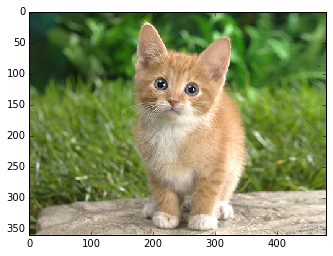

In [13]:
img = skimage.io.imread('cat.jpg').astype('float32') / 255
matplotlib.pyplot.imshow(img, interpolation='none')

Run all tests.

In [14]:
print "Testing on CPU"
print "=============="

test_linear(img)
test_cubic(img)
test_lanczos4(img)

print "=============="
print "Testing on GPU"
print "=============="

gpu_id = 1

test_linear(img, gpu_id)
test_cubic(img, gpu_id)
test_lanczos4(img, gpu_id)

print "=============="

Testing on CPU
linear:
factor 2 2: OK
factor 3 2: OK
factor 4 2: OK
factor 5 2: OK
factor 2 3: OK
factor 3 3: OK
factor 4 3: OK
factor 5 3: OK
factor 2 4: OK
factor 3 4: OK
factor 4 4: OK
factor 5 4: OK
factor 2 5: OK
factor 3 5: OK
factor 4 5: OK
factor 5 5: OK
cubic:
factor 2 2: OK
factor 3 2: OK
factor 4 2: OK
factor 5 2: OK
factor 2 3: OK
factor 3 3: OK
factor 4 3: OK
factor 5 3: OK
factor 2 4: OK
factor 3 4: OK
factor 4 4: OK
factor 5 4: OK
factor 2 5: OK
factor 3 5: OK
factor 4 5: OK
factor 5 5: OK
lanczos4:
factor 2 2: OK
factor 2 3: OK
factor 2 4: OK
factor 2 5: OK
factor 3 2: OK
factor 3 3: OK
factor 3 4: OK
factor 3 5: OK
factor 4 2: OK
factor 4 3: OK
factor 4 4: OK
factor 4 5: OK
factor 5 2: OK
factor 5 3: OK
factor 5 4: OK
factor 5 5: OK
Testing on GPU
linear:
factor 2 2: OK
factor 3 2: OK
factor 4 2: OK
factor 5 2: OK
factor 2 3: OK
factor 3 3: OK
factor 4 3: OK
factor 5 3: OK
factor 2 4: OK
factor 3 4: OK
factor 4 4: OK
factor 5 4: OK
factor 2 5: OK
factor 3 5: OK
factor 

# Visualize kernels

Show example kernels. Modify support, method and factor for visualizing other kernels.

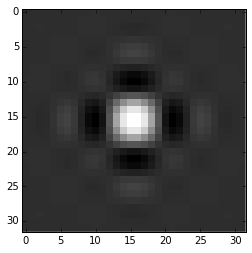

In [9]:
support = 4
method = 'lanczos4'
factor = (4, 4)
net_file = python_net_file((1, 1, 32, 32), factor, method, support)
net = caffe.Net(net_file, caffe.TEST)
os.remove(net_file)
data = net.params['upsample'][0].data[0,0]
matplotlib.pyplot.imshow(data, cmap='Greys_r', interpolation='none');